# Getting started

## Fitting a data to a user defined model

*refnx* can examine most curve fitting problems. Here we demonstrate a fit to a simple user defined model. This line example is taken from the [emcee documentation](http://emcee.readthedocs.io/en/stable/user/line.html) and the reader is referred to that link for more detailed explanation. The errorbars are underestimated, and the modelling will account for that.

To use *refnx* we need first need to create a dataset. We create a synthetic dataset

In [1]:
%matplotlib inline

import numpy as np

rng = np.random.default_rng(1220289787)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

N = 50
x = np.sort(10 * rng.uniform(size=N))
yerr = 0.1 + 0.5 * rng.uniform(size=N)
y = m_true * x + b_true
y += np.abs(f_true * y) * rng.normal(size=N)
y += yerr * rng.normal(size=N)

We create a `Data1D` object from this synthetic data:

In [2]:
from refnx.dataset import Data1D

data = Data1D(data=(x, y, yerr))

Then we need to set up a generative model. Firstly we write a fit-function that returns our straight line model. The `Parameter` objects describe the parameters we're going to use in the fit. We give the parameters values, names, and specify their limits. The parameters are combined into a `Parameters` set, `p`, using the or operator.
Then we create a `Model` object from our parameter set and the fit-function. 

In [3]:
from refnx.analysis import Parameter, Model


def line(x, params, *args, **kwds):
    p_arr = np.array(params)
    return p_arr[0] + x * p_arr[1]


# the model needs parameters
p = Parameter(1, "b", vary=True, bounds=(0, 10))
p |= Parameter(-2, "m", vary=True, bounds=(-5, 0.5))

model = Model(p, fitfunc=line)

We set lower and upper limits on each of the parameters. This means that the log-prior probability from those parameters is described by a uniform distribution. Only solutions which have finite probability (i.e. lie between the limits) will be considered by the fit/sampler.

In [4]:
# ln(1 / 10)
# a value lying outside the limits is not possible
print(p[0].logp(1), p[0].logp(-1))

-2.3025850929940455 -inf


It's not required to give each parameter bounds unless the fit method requires it. The bounds do not have to be from a uniform distribution, any of the `scipy.stats.rv_continuous` distributions can be used:

```
import scipy.stats as stats
# a normal distribution of mean 5 and standard deviation 1.
p[0].bounds = stats.norm(5, 1)
```

Now we create an `Objective` from the model and the data. We use an extra parameter, `lnsigma`, to describe the underestimated error bars. Objectives use the model and data to calculate statistics about the curve fitting system.

In [5]:
from refnx.analysis import Objective

lnf = Parameter(0, "lnf", vary=True, bounds=(-10, 1))
objective = Objective(model, data, lnsigma=lnf)
print(objective.chisqr(), objective.logp(), objective.logl(), objective.logpost())

631.1788336329323 -6.405228458030841 -440.09147816937787 -446.4967066274087


Then a `CurveFitter` is created from the `Objective`. This is responsible for doing all the curvefitting/Bayesian sampling. Let's do a quick fit using Differential Evolution.

In [6]:
from refnx.analysis import CurveFitter

fitter = CurveFitter(objective)
fitter.fit("differential_evolution");

61.78490690835281: : 20it [00:00, 436.03it/s] 


In the final output of the sampling each varying parameter is given a set of statistics. `Parameter.value` is the median of the chain samples. `Parameter.stderr` is half the [15, 85] percentile, representing a standard deviation.

________________________________________________________________________________
Objective - 4491965312
Dataset = <None>, 50 points
datapoints = 50
chi2 = 45.73166955271531
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:      None      
<Parameter:      'b'      , value=4.74604 +/- 0.261, bounds=[0.0, 10.0]>
<Parameter:      'm'      , value=-1.09134 +/- 0.0598, bounds=[-5.0, 0.5]>
<Parameter:     'lnf'     , value=-1.16894 +/- 0.202, bounds=[-10.0, 1.0]>


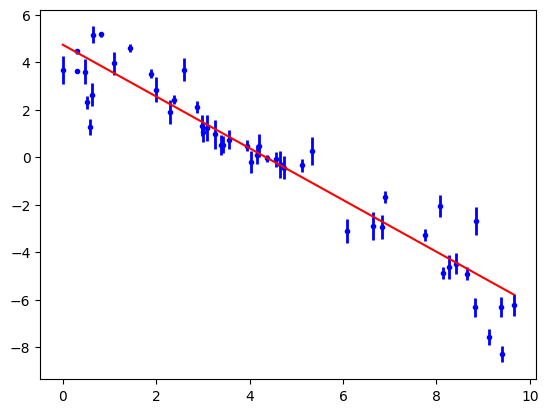

In [7]:
print(objective)
objective.plot();

The trouble with a single fit that minimises $\chi^2$ is that it doesn't reveal the range of solutions that are consistent with the data. It also assumes that the parameter uncertainties will be normally distributed and uni-modal. To investigate the parameter probability distributions we need to use MCMC to sample the posterior probability distribution of the system. 

Note: `pool=` specifies that no parallelisation is done during sampling. On platforms that use `spawn` for multiprocessing special precautions [must be used](https://docs.python.org/3/library/multiprocessing.html#the-spawn-and-forkserver-start-methods) when using `pool > 1`.

In [8]:
fitter.sample(1000, pool=1);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.77it/s]


Once the sampling is done we burn/discard some of the initial steps because the initial locations of the walkers won't be around their 'equilibrium' position. We thin out the chain to reduce auto-correlation between successive steps.

In [9]:
from refnx.analysis import process_chain

process_chain(objective, fitter.chain, nburn=300, nthin=100, flatchain=True)
print(objective.parameters)

________________________________________________________________________________
Parameters:      None      
<Parameter:      'b'      , value=4.76502 +/- 0.269, bounds=[0.0, 10.0]>
<Parameter:      'm'      , value=-1.09578 +/- 0.06 , bounds=[-5.0, 0.5]>
<Parameter:     'lnf'     , value=-1.1538 +/- 0.154, bounds=[-10.0, 1.0]>


Now we can see the range of solutions that are consistent with the data:

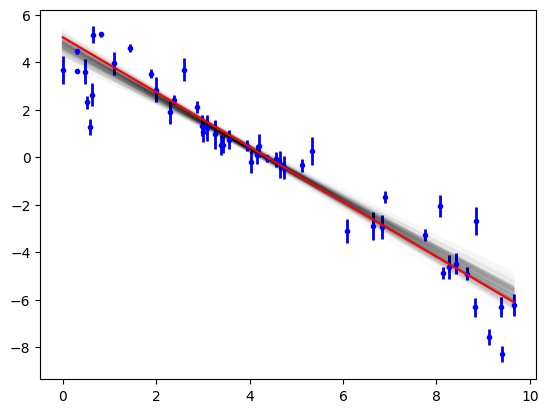

In [10]:
objective.plot(samples=300);

## Fitting a neutron reflectometry dataset

We start off with all the relevant imports we'll need.

In [11]:
from importlib import resources
import numpy as np
import matplotlib.pyplot as plt
import scipy

import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel

It's important to note down the versions of the software that you're using, in order for the analysis to be reproducible.

In [12]:
print(
    f"refnx: {refnx.version.version}\n"
    f"scipy: {scipy.version.version}\n"
    f"numpy: {np.version.version}"
)

refnx: 0.1.53.dev0+19c4b26
scipy: 1.15.2
numpy: 2.1.3


### Loading/Creating a dataset

*refnx* reads 2, 3, or 4 column plain-text files using `Data1D` or `ReflectDataset`.


| columns |   data                  |
|---------|-------------------------|
|  2      |         $x, y$          |
|  3      |    $x, y, y_{err}$      |
|  4      |$x, y, y_{err}, x_{err}$ |


$y_{err}$ being the standard deviation of the measured $y$ data, $x_{err}$ being the uncertainty in $x$.

In a reflectometry context $x$ is the momentum transfer $Q$ ($A^{-1}$), $y_{err}$ is the uncertainty in the reflectivity, and $x_{err}$ is the full width at half maximum (FWHM) of the Gaussian approximation to the resolution function, $dQ$.

The dataset we're going to use as an example is distributed with every install. The following cell determines its location.

In [13]:
with resources.path(refnx.analysis) as pth:
    DATASET_NAME = "c_PLP0011859_q.txt"
    file_path = pth / f"tests/{DATASET_NAME}"

`ReflectDataset` uses a file path to load the data. However, you can also make a dataset directly from numerical arrays.

In [14]:
data = ReflectDataset(file_path)

### Creating an interfacial Structure

`Structure` objects describe the interface of interest. They are made by assembling a series of `Components` (the simplest `Component` being a `Slab`. However, the first step is to create `SLD` objects that represent each of the materials:

In [15]:
si = SLD(2.07, name="Si")
sio2 = SLD(3.47, name="SiO2")
film = SLD(2.0, name="film")
d2o = SLD(6.36, name="d2o")

`Slab`s are created from these `SLD`s to represent each layer in the system.

In [16]:
# first number is thickness, second number is roughness
# a native oxide layer
sio2_layer = sio2(30, 3)

# the film of interest
film_layer = film(250, 3)

# layer for the solvent
d2o_layer = d2o(0, 3)

A `Slab` has the following parameters, which are all accessible as attributes:

 - `Slab.thick`
 - `Slab.sld.real`
 - `Slab.sld.imag`
 - `Slab.rough`
 - `Slab.vfsolv`
 
We need to specify which parameters are going to vary in a fit, and what the limits are on those parameters. 

In [17]:
sio2_layer.thick.setp(bounds=(15, 50), vary=True)
sio2_layer.rough.setp(bounds=(1, 15), vary=True)

film_layer.thick.setp(bounds=(200, 300), vary=True)
film_layer.sld.real.setp(bounds=(0.1, 3), vary=True)
film_layer.rough.setp(bounds=(1, 15), vary=True)

d2o_layer.rough.setp(vary=True, bounds=(1, 15))

Now we assemble the `Structure` from the `Components`.

In [18]:
structure = si | sio2_layer | film_layer | d2o_layer

In [19]:
print(sio2_layer.parameters)

________________________________________________________________________________
Parameters:     'SiO2'     
<Parameter:'SiO2 - thick' , value=30          , bounds=[15.0, 50.0]>
________________________________________________________________________________
Parameters:     'SiO2'     
<Parameter: 'SiO2 - sld'  , value=3.47  (fixed) , bounds=[-inf, inf]>
<Parameter: 'SiO2 - isld' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'SiO2 - rough' , value=3          , bounds=[1.0, 15.0]>
<Parameter:'SiO2 - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>


`Structure` has a `sld_profile` method to return the SLD profile. Let's also plot that.

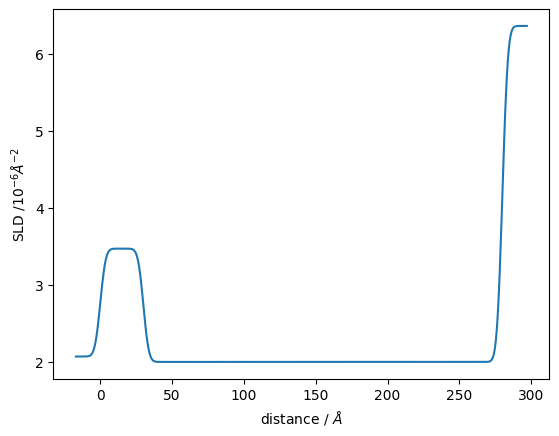

In [20]:
plt.plot(*structure.sld_profile())
plt.ylabel("SLD /$10^{-6} \\AA^{-2}$")
plt.xlabel("distance / $\\AA$");

### `ReflectModel` calculates the generative model.

A `ReflectModel` is made from the `Structure` and is responsible for calculating the reflectivity of the system. `ReflectModel` performs resolution smearing, applies scaling factor and adds a Q-independent constant background. It can use constant `dq/q`, point-by-point, and full resolution kernel smearing. The resolution parameter, `dq`, can be fitted, but this will only be valid if your dataset didn't supply the instrument resolution.

In [21]:
model = ReflectModel(structure, bkg=3e-6, dq=5.0)
model.scale.setp(bounds=(0.6, 1.2), vary=True)
model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)

Let's quickly have a look at the model generated by the structure:

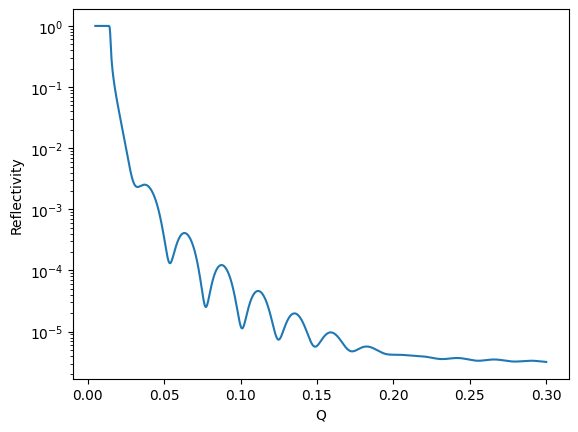

In [22]:
q = np.linspace(0.005, 0.3, 1001)
plt.plot(q, model(q))
plt.xlabel("Q")
plt.ylabel("Reflectivity")
plt.yscale("log")

### `Objective` combines the model and data, calculating statistics

An `Objective` is made from a model and dataset. Here we use a `Transform` to fit as logY vs X.

In [23]:
objective = Objective(model, data, transform=Transform("logY"))

The `Objective` can calculate statistics for the fitting system. Note how the log-probability is the sum of the log-prior and log-likelihood.

In [24]:
print(objective.chisqr(), objective.logp(), objective.logl(), objective.logpost())

34376.69092305149 -5.013178251637257 -16157.42806574066 -16162.441243992296


### `CurveFitter` does the fitting/sampling

The final setup step is to create a `CurveFitter` from the `Objective`. These objects do the fitting/sampling. Let's do an initial fit with differential evolution.

In [25]:
fitter = CurveFitter(objective)
fitter.fit("differential_evolution");

-568.738983169657: : 52it [00:02, 19.65it/s]  


An `Objective` has a plot method, which is a quick visualisation. You need matplotlib installed to create a graph. You can see that the fit looks good.

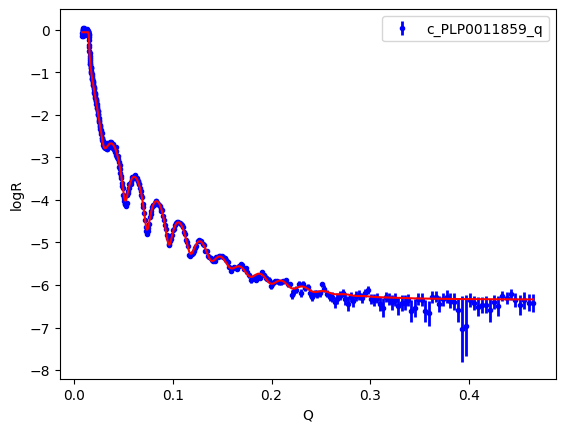

In [26]:
objective.plot()
plt.legend()
plt.xlabel("Q")
plt.ylabel("logR")
plt.legend();

Let's see the results of the fit. For the case of DifferentialEvolution uncertainties are estimated by estimating the Hessian/Covariance matrix.

In [27]:
print(objective)

________________________________________________________________________________
Objective - 4510182416
Dataset = c_PLP0011859_q
datapoints = 408
chi2 = 922.9880511274863
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.877796 +/- 0.00304, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.56889e-07 +/- 2.15e-08, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution', value=5  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Si'      
<Parameter: 'Si - thick'  , value=0  (fixed) 

Now lets do a MCMC sampling of the curvefitting system. First we do 400 samples which we then discard (burn). These samples are discarded because the initial chain might not be representative of an equilibrated system (i.e. distributed around the mean with the correct covariance).

In [28]:
fitter.sample(400, pool=-1)
fitter.reset()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:19<00:00, 20.36it/s]


We then follow up with a production run, only saving 1 in 100 samples. This is to remove autocorrelation. We save 15 steps, giving a total of 15 * 200 samples (200 walkers is the default).

In [29]:
res = fitter.sample(15, nthin=100, pool=-1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:17<00:00, 19.37it/s]


In the final output of the sampling each varying parameter is given a set of statistics. `Parameter.value` is the median of the chain samples. `Parameter.stderr` is half the [15, 85] percentile, representing a standard deviation.

In [30]:
print(objective)

________________________________________________________________________________
Objective - 4510182416
Dataset = c_PLP0011859_q
datapoints = 408
chi2 = 919.5964109463828
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.879261 +/- 0.003, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.5936e-07 +/- 2.27e-08, bounds=[1e-09, 9e-06]>
<Parameter:'dq - resolution', value=5  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Si'      
<Parameter: 'Si - thick'  , value=0  (fixed) , b

A corner plot shows the covariance between parameters. You need to install the *matplotlib* and *corner* packages to create these graphs.

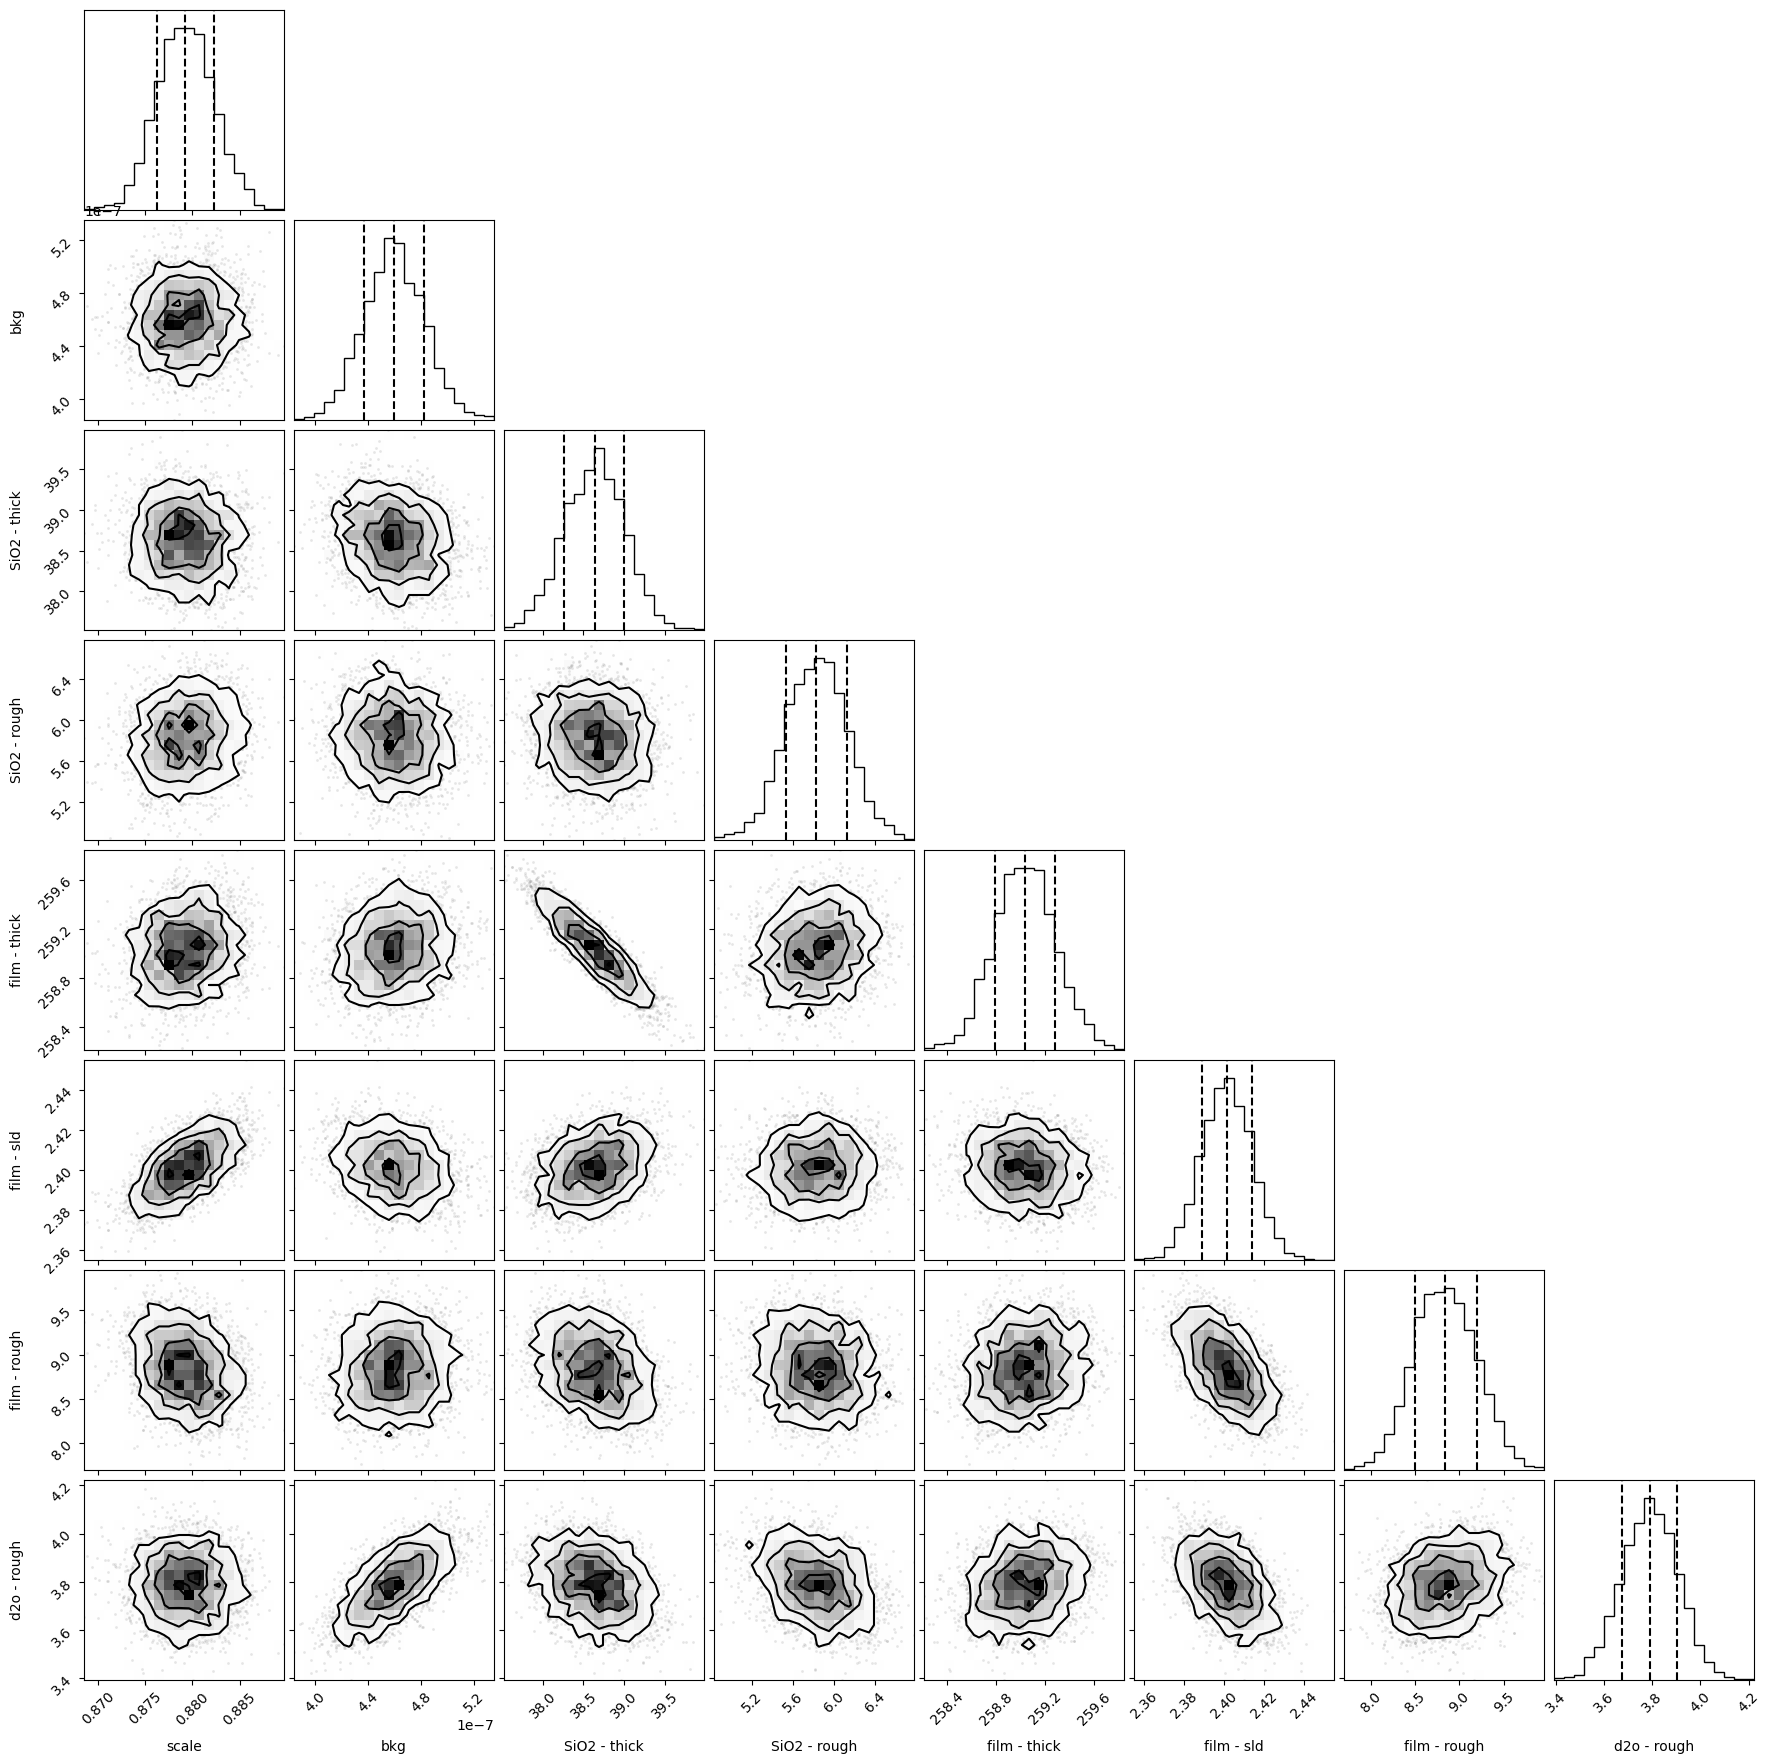

In [31]:
objective.corner();

Once we've done the sampling we can look at the variation in the model at describing the data. In this example there isn't much spread.

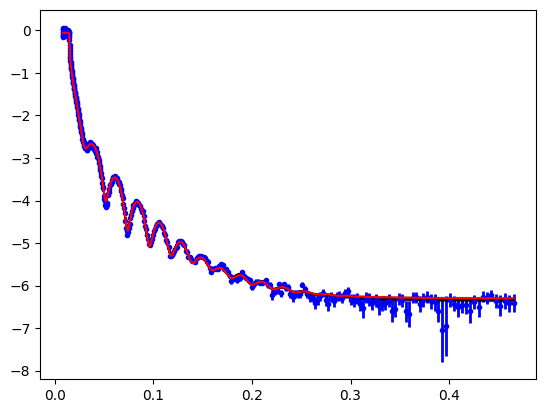

In [32]:
objective.plot(samples=300);

In a similar manner we can look at the spread in SLD profiles consistent with the data.

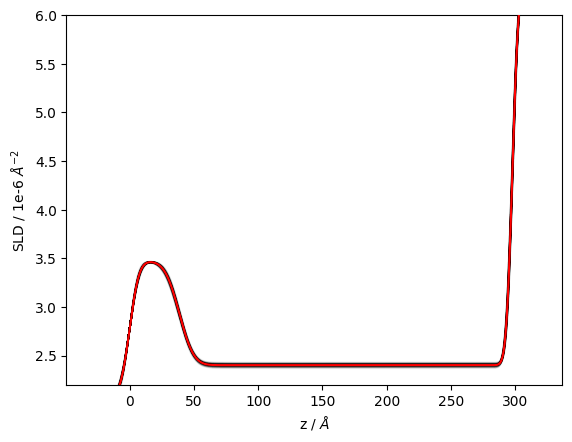

In [33]:
structure.plot(samples=300)
plt.ylim(2.2, 6);

## Fitting the BornAgain example

[BornAgain](https://www.bornagainproject.org/) is another program for fitting reflectometry and GISAS data. The following cells repeat the analysis in their [specular fitting example]( https://github.com/scgmlz/BornAgain/blob/master/Examples/python/fitting/ex03_ExtendedExamples/specular/FitSpecularBasics.py). The simulated thickness of the Titanium layer is 30 Angstrom, but we'll start the fit with a value of 50.

In [34]:
# necessary imports
import numpy as np
from refnx.util import q
from refnx.analysis import Objective, CurveFitter, Transform
from refnx.dataset import Data1D
from refnx.reflect import SLD, Stack, ReflectModel

In [35]:
# first grab the data from the BornAgain repository.
# The data was originally created in genx.
import requests as req
import io
import gzip

url = (
    "https://jugit.fz-juelich.de/mlz/bornagain/-/raw/main/"
    "testdata/specular/genx_alternating_layers.dat.gz?inline=false"
)
f = gzip.open(io.BytesIO(req.get(url).content))
dataset = np.loadtxt(f, usecols=(0, 1), skiprows=3).T

# data is saved as two_theta, convert to Q.
dataset[0] = q(dataset[0] / 2, 1.54)

In [36]:
# make a dataset
data = Data1D(data=dataset)

In [37]:
# make the structure
air = SLD(0)
si = SLD(2.0704)  # silicon substrate
ni = SLD(9.4245)  # nickel
ti = SLD(-1.9493)  # titanium

# make the layers
ti_layer = ti(50)
ni_layer = ni(70)

# Make a multilayer by using a Stack Component
stack = Stack()
stack |= ti_layer
stack |= ni_layer
stack.repeats.value = 10

structure = air | stack | si(0, 0)

# put the Structure in a Model
model = ReflectModel(structure, bkg=0, dq=0)

In [38]:
# we're only going to fit the Titanium thickness
ti_layer.thick.setp(vary=True, bounds=(10, 60))

# now do the fit
objective = Objective(model, data, transform=Transform("logY"))
fitter = CurveFitter(objective)

1.0115394037801482e-07: : 25it [00:00, 96.44it/s]


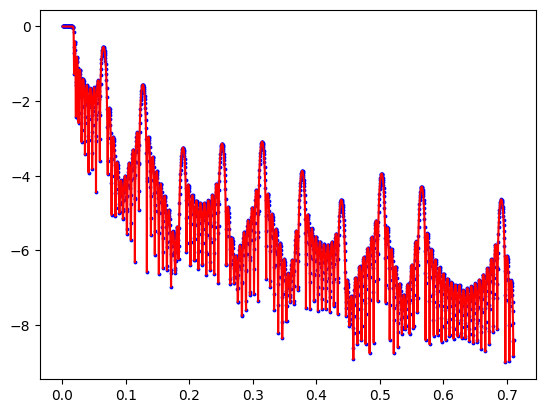

In [39]:
# now fit and plot
fitter.fit("differential_evolution")
fig, ax = objective.plot()

In [40]:
print(objective.chisqr())
print(ti_layer)

2.023074484566843e-07
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=30 +/- 4.43e-08, bounds=[10.0, 60.0]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:   ' - sld'    , value=-1.9493  (fixed) , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
